In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [2]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/910-911/910-911psfdffkf179Smith0_4_60TS.mat


In [3]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(13894, 179)

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/910-911/910-911psfdffkf179Smith0_4_60IC.nii


In [5]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(83, 44, 10, 179)

In [6]:
S=data.shape
S

(83, 44, 10, 179)

Z-score

In [7]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [8]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [9]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [10]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/910-911/910_911registration/JFRCTransformedLargefullpsftrimmed.nii


In [11]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [12]:
RegNum=dict(zip(RegionName,Num))

In [13]:
RegNum['OL']

1

# Average in masks to sort components by brain region

In [14]:
Dmaps.shape

(83, 44, 10, 179)

In [15]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [16]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [17]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [18]:
J

[6]

OL


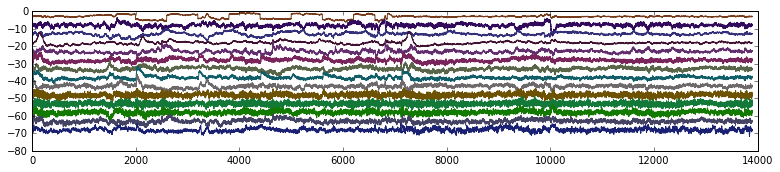

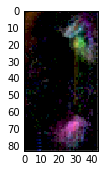

VLNP


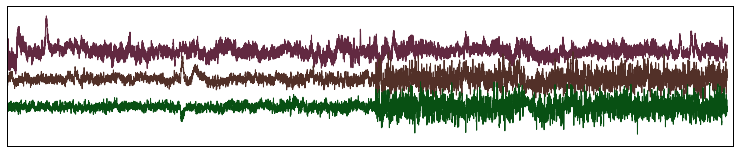

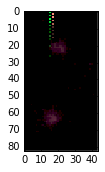

AL


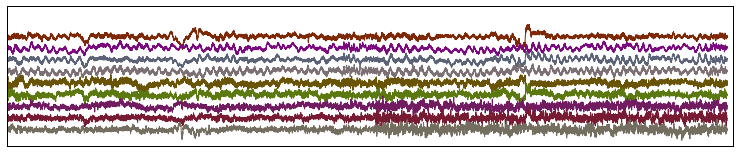

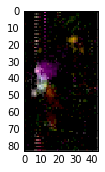

MB


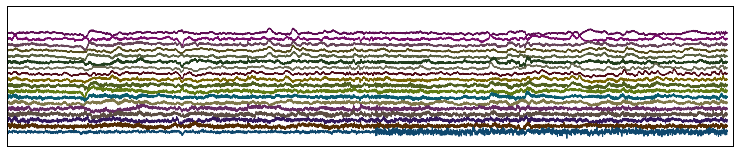

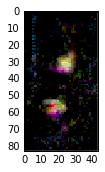

LH


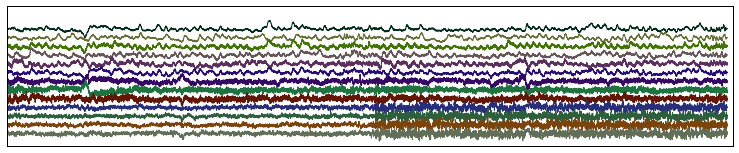

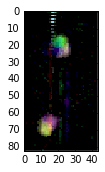

SNP


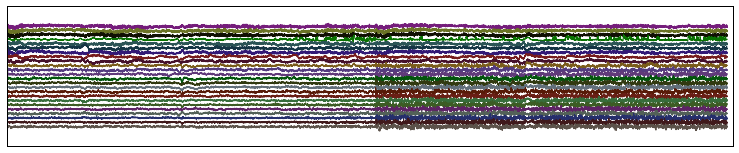

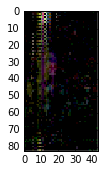

CX


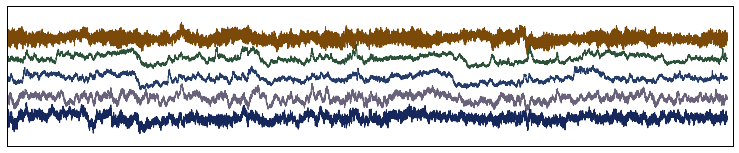

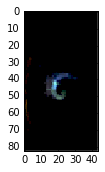

LX


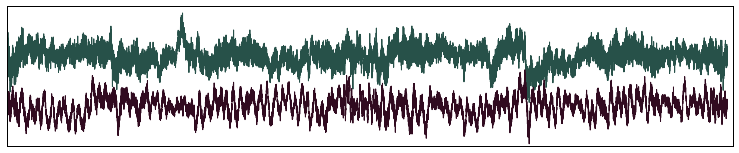

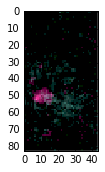

PENP


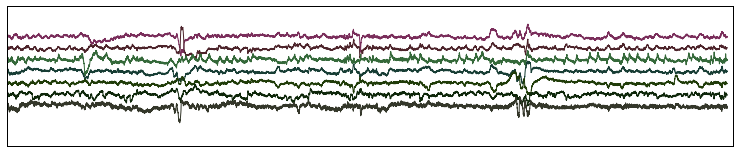

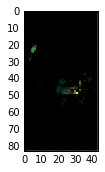

GNG


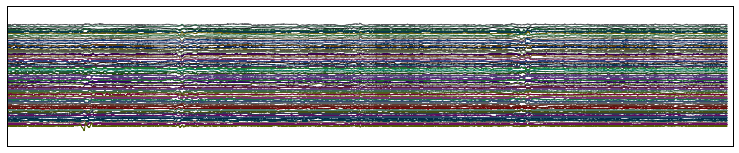

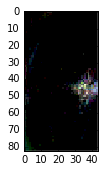

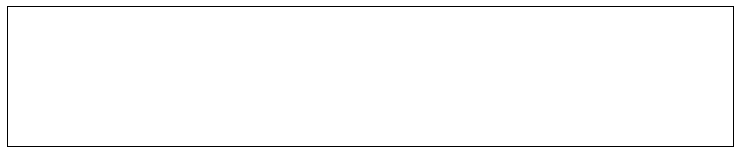

In [19]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [27]:
BadICs=[131,30,59,0,1,12,19,27,50,51,119,146,98,21,41,157,154,162,194,147,126,65,2,39,60,68,79,22,144,143,16,52,37,40,38,45,4,20,24,29,44,47,57,76,49,56,64,66,70,75,78,82,84,100,135,166,85,3,5,36,8,46,63,193,7,108,31,58,101]

In [28]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

13
42
53
54
55
69
71
77
92
97
99
112
121
123
138
148
172
186
OL


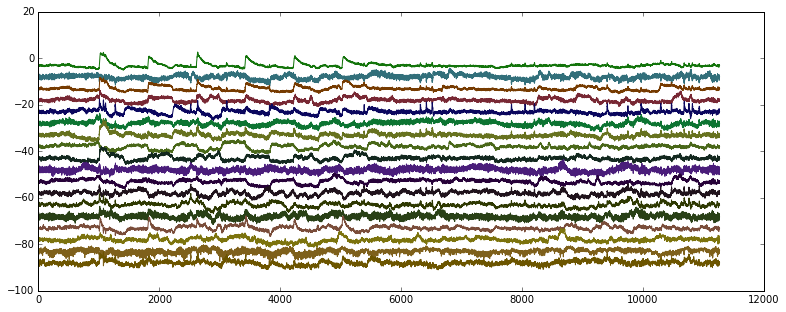

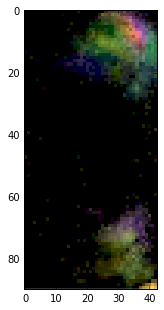

94
VLNP


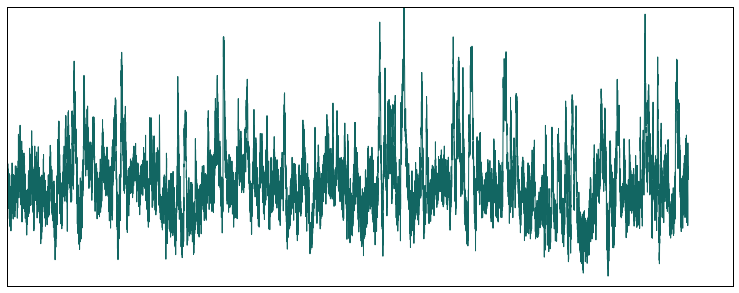

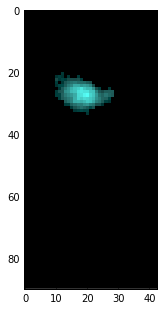

104
VMNP


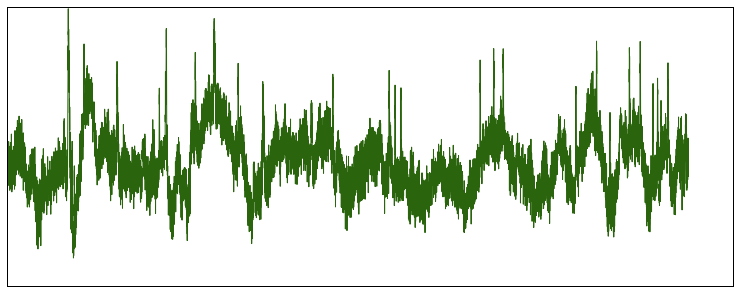

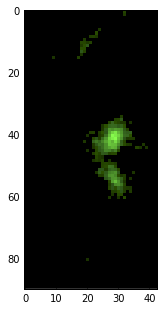

9
74
86
87
88
89
90
93
107
109
114
117
165
AL


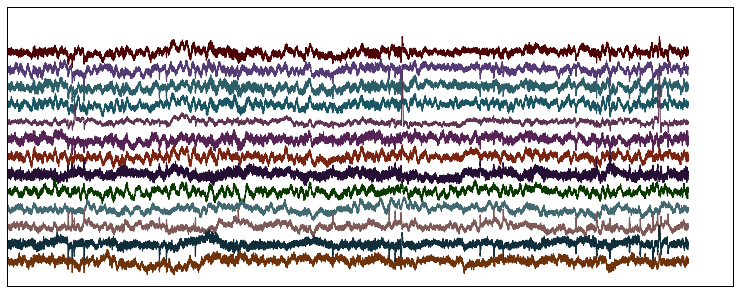

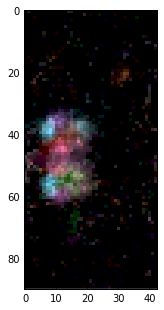

6
10
11
15
17
23
28
32
33
34
35
43
48
67
72
81
91
95
118
127
133
134
136
150
161
MB


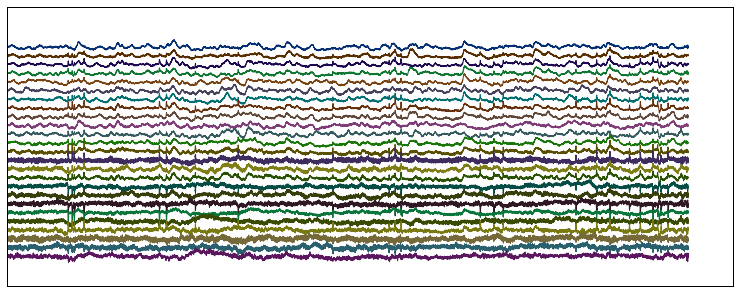

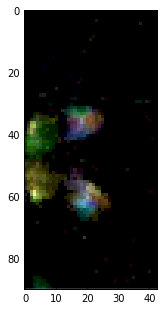

14
25
26
61
62
73
102
103
111
LH


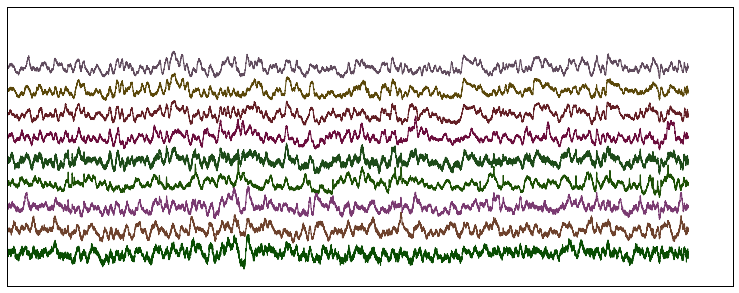

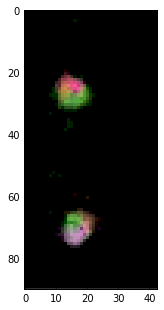

140
145
158
163
168
170
176
SNP


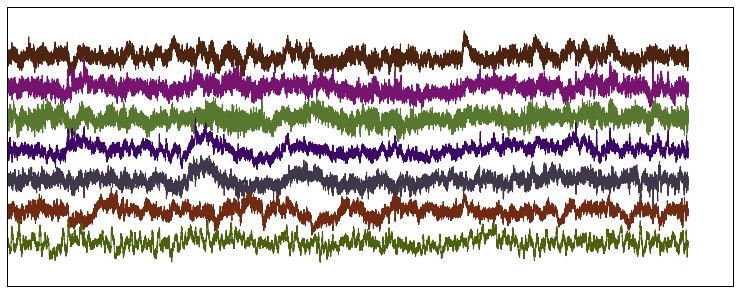

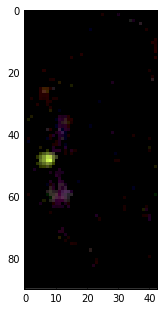

80
83
CX


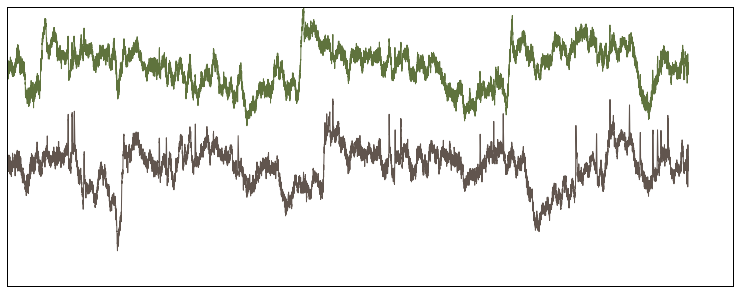

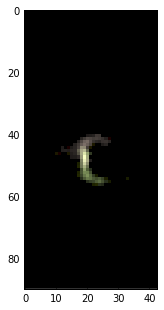

128
PENP


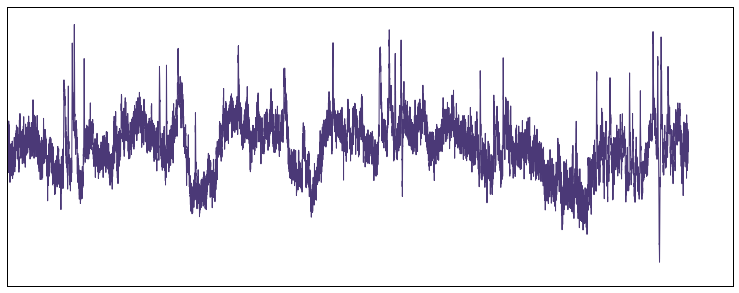

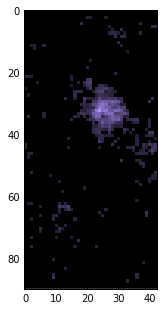

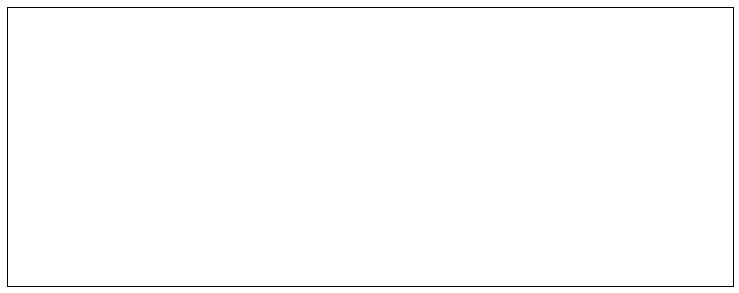

In [29]:
pylab.rcParams['figure.figsize'] = (13, 5)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.2)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

In [20]:
BadICs=[91,152,28,4,29,55,89,59,102,175,93,119,0,145,154,155,156,163,166,167,170,174,62,129,159,162,164,169,171,178,78,153,161,61,143,87,148,134,68,7,8,10,15,23,27,39,42,46,51,64,70,82,22,33,34,135,20,95,158,149,146,141,81,150,40,112,84,1,2,3,5,6,11,16,19,21,24,25,37,38,41,43,47,48,50,57,65,69,73,77,79,86,90,92,94,96,115,120,122,125,124,97,104,105,113,116,128,132,138,108,157,165,168,172,177,173,140]

In [21]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/910-911/910_911StimXk.mat


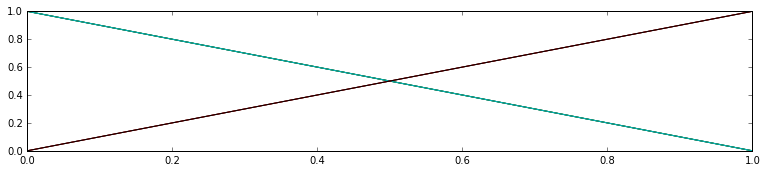

In [22]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
X=Ua['X']

plt.plot(X)

Sx=X.shape

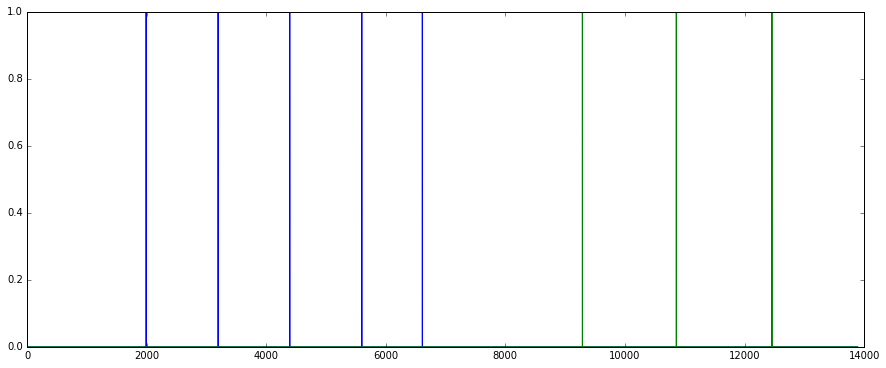

In [35]:
plt.plot(X)
X=X.T

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/910-911/910_911registration/AVG_910regc.nii


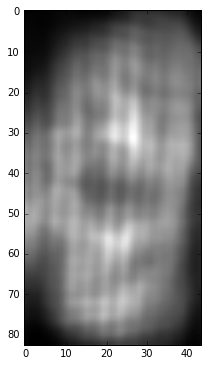

In [36]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenamet = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenamet)
nimt=nb.load(filenamet)
Dtemp=np.squeeze(nimt.get_data())
Dtemp.shape

if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

for j in range(S[3]):

    a=''
    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],j]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan

plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [55]:
DT.shape

(13894, 179)

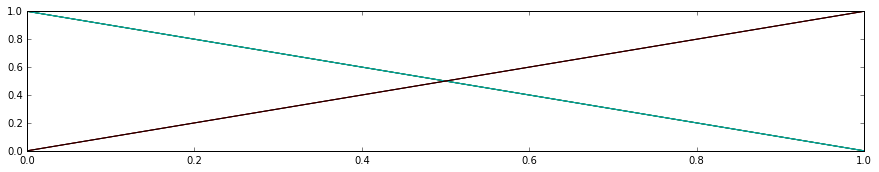

In [58]:
plt.plot(X.T)
X=X.T

In [66]:
X.shape

(2, 13894)

In [70]:
Sx

(13894, 2)

In [73]:
AvLightIC=np.zeros(DT.shape[1])        
for j in range(S[3]):
    k=0
    for i in range(Sx[0]):
        if X[0,i]==1:
            AvLightIC[j]=AvLightIC[j]+(np.mean(DT[i:i+200,j])-np.mean(DT[i-200:i,j]))/(2*np.std(DT[i-200:i,j]))
            k=k+1
    AvLightIC[j]=AvLightIC[j]/k

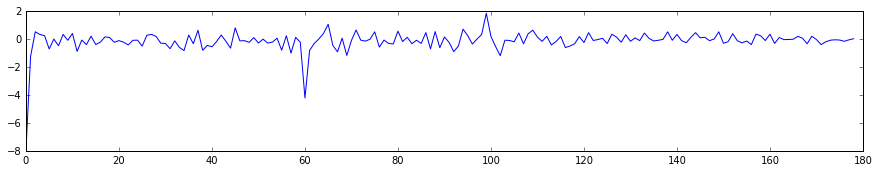

In [75]:
plt.plot(AvLightIC)

In [76]:
AvOdorIC=np.zeros(DT.shape[1])        
for j in range(S[3]):
    k=0
    for i in range(Sx[0]):
        if X[1,i]==1:
            AvOdorIC[j]=AvOdorIC[j]+(np.mean(DT[i:i+200,j])-np.mean(DT[i-200:i,j]))/(2*np.std(DT[i-200:i,j]))
            k=k+1
    AvOdorIC[j]=AvOdorIC[j]/k

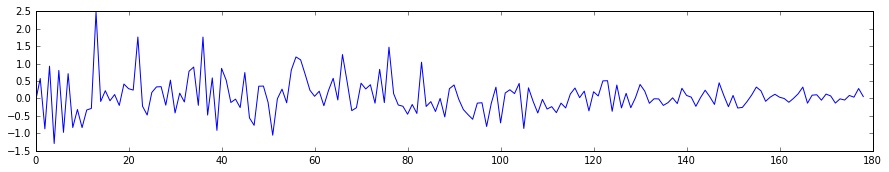

In [78]:
plt.plot(AvOdorIC)

In [77]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
pylab.rcParams['figure.figsize'] = (15, 2.5)

In [79]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [80]:
C=np.zeros((S[3],3))
i=0
l=0

LightNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if AvLightIC[j]>1:
        #C[j,:]=C1[i%6][:]
        C[j,2]=1
        C[j,1]=1
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.5*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(CompMainName[j])     
        
        i=i+1
        l=l+1
        LightNuminRegion[int(CompMainName[j])-1]=LightNuminRegion[int(CompMainName[j])-1]+1
        #if l==2:
            #break
    

66
12
100
1


In [81]:
LightNuminRegion

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [82]:
C=np.zeros((S[3],3))
i=0
l=0

OdorNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if AvOdorIC[j]>1:
        #C[j,:]=C1[i%6][:]
        C[j,0]=1
        C[j,1]=0
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.5*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(CompMainName[j])     
        OdorNuminRegion[int(CompMainName[j])-1]=OdorNuminRegion[int(CompMainName[j])-1]+1        
        i=i+1
        l=l+1

14
5
23
11
37
5
57
5
58
12
67
5
77
5
84
5


In [83]:
OdorNuminRegion

array([ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  1.,  1.])

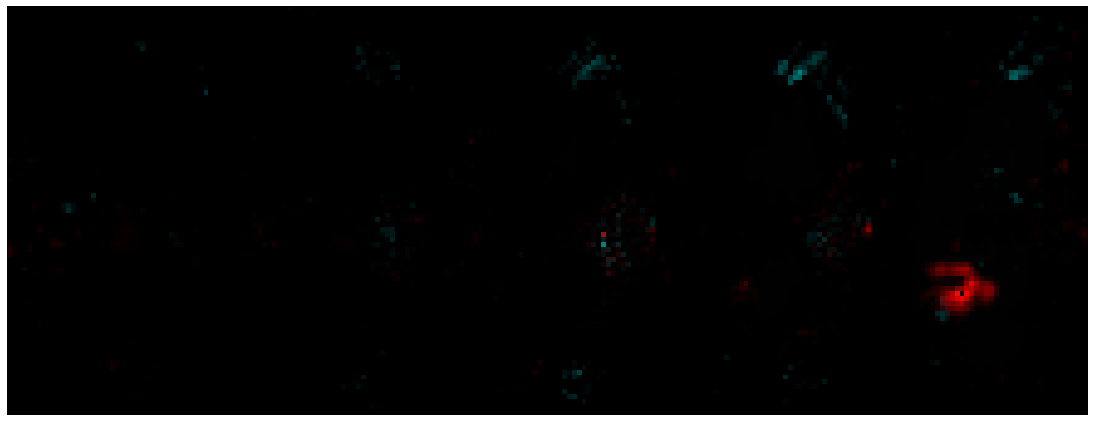

In [84]:
pylab.rcParams['figure.figsize'] = (15, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/500
    #Df=Df/(np.max(np.max(np.max(Df),3)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Df[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [86]:
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsLight.txt',LightNuminRegion)
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsOdor.txt',OdorNuminRegion)